<a href="https://colab.research.google.com/github/sdevries0/ISMI_group13/blob/main/NCDE_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import jax
# from jax.lib import xla_bridge
# print(xla_bridge.get_backend().platform)

In [2]:
!pip install jaxlib==0.4.2
!pip install diffrax
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import jax
# from jax.config import config
# config.update("jax_enable_x64", True)
from math import pi
import numpy as np
#from utils import plot_system, SinusoidalControlPath
import matplotlib.pyplot as plt
import diffrax as dfx
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy as jsp
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import seaborn as sns
import pandas as pd
# from equinox.custom_types import Array
import math
from typing import Callable
import seaborn as sns
x = jrandom.uniform(jrandom.PRNGKey(0), (1,), dtype=jnp.float64)
x.dtype # --> dtype('float64')

dtype('float32')

In [4]:
# Define control path with multiple different functions. t is added to the resulting array. 
class MultiControlPath(dfx.AbstractPath):

    C : int
    phase: Callable
    frequency: Callable

    def __init__(self, phase, frequency, C = 2):
      self.C = C
      self.phase = phase
      self.frequency = frequency

    def evaluate(self, t0, t1=None, left=True):
      del left
      if t1 is not None:
        return self.evaluate(t1) - self.evaluate(t0)
      #Evaluate t0 and t1 for each sinoid control 
      controls_at_t = jnp.array([jnp.sin(self.phase[i] + self.frequency[i] * t0) for i in range(self.C)])
      # return jnp.append(t0, controls_at_t)
      return controls_at_t

In [5]:
class CDE():
    
    f_state : Callable
    f_obs : Callable

    def __init__(self, f_state, f_obs = lambda x: x):
        """
        params:
            f_state: vector field; function dom_state -> dom_state x dom_ctrl
            f_obs: linear readout (complete observability by default); function dom_ctrl -> dom_obs
        """
        self.f_state = f_state
        self.f_obs = f_obs
 
    def __call__(self, ts, params, init):
        """
        Generates states at specified times ts given a control
 
        params:
            ts: time points
            phase: phases used for control
            frequency: frequencies used for control
            init: initial state of the CDE 
        """
        #Create control
        control = MultiControlPath(params[0], params[1], params[1].shape[-1])
        system = dfx.ODETerm(self.f_state)
        solver = dfx.Tsit5()
        dt0=(ts[1]-ts[0])/2
        
        #Solve differential equation
        sol = dfx.diffeqsolve(
            system,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0=init,
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts),
            args=control,
        )

        # return phase, frequency, initial state, hidden states and observations
        return sol.ys, jax.vmap(self.f_obs)(sol.ys)

In [6]:
class Dataloader():
    def __init__(self, system, key, batch_size, N, C, sd, dataset_size, test_size, ts):
      assert dataset_size%batch_size == 0
      self.dataset_size = dataset_size
      self.batch_size = batch_size
      keys = jrandom.split(key, 4)

      #train data
      self.frequency = jrandom.uniform(keys[0], shape=(self.dataset_size, C), minval = 0.5, maxval = 1.5)
      self.phase = jrandom.normal(keys[1], shape=(self.dataset_size, C))
      self.params = jnp.stack([self.phase, self.frequency],axis=1)
      init = sd*jrandom.normal(keys[2], shape=(self.dataset_size, N))
      self.sample_key = keys[3]
      _, self.dataset = jax.vmap(system, in_axes=[None, 0, 0])(ts, self.params, init)

      #test data
      test_keys = jrandom.split(jrandom.fold_in(key, 5), 3)
      self.test_frequency = jrandom.uniform(keys[0], shape=(test_size, C), minval = 0.5, maxval = 1.5)
      self.test_phase = jrandom.normal(keys[1], shape=(test_size, C))
      self.test_params = jnp.stack([self.test_phase, self.test_frequency],axis=1)
      test_init = sd*jrandom.normal(keys[2], shape=(test_size, N))
      self.test_hidden_states, self.testset = jax.vmap(system, in_axes=[None, 0, 0])(ts, self.test_params, test_init)

    def sample_observations(self, epoch):
      new_key = jrandom.fold_in(self.sample_key, epoch)
      indices = jrandom.randint(new_key,shape=(self.batch_size,),minval=0,maxval=self.dataset_size)

      return self.params[indices], self.dataset[indices]

    def get_testdata(self):
      return self.test_params, self.testset, self.test_hidden_states

In [7]:
class NeuralCDE(eqx.Module):
    
    f_state : Callable
    f_init : Callable
    f_obs : Callable
    t0: int

    def __init__(self, f_state, f_obs = lambda x: x, f_init = None, t0 = 0, **kwargs):
        """
        params:
            f_state: vector field; function dom_state -> dom_state x dom_ctrl
            f_obs: linear readout (complete observability by default); function dom_state -> dom_obs
            f_init: initial state; function dom_obs -> dom_state 
            t0: starting point of NCDE
        
        Each term can be either a fixed function (CDE) or a parameterized nonlinear function (neural CDE)

        """
        super().__init__(**kwargs)
        self.f_state = f_state
        self.f_obs = f_obs
        self.f_init = f_init
        self.t0 = t0

    def __call__(self, ts, params, obs):
        """
        Generates states at specified times ts given a control
        The initial state is determined using another NCDE which receives the first observation and control
        """
        #Create control
        control = MultiControlPath(params[0], params[1], params[1].shape[-1])
        system = dfx.ODETerm(self.f_state)

        # #Determine initial state
        y0 = self.f_init(ts[:self.t0], params, obs)

        solver = dfx.Tsit5()
        dt0=(ts[1]-ts[0])/2

        #Solve differential equation
        sol = dfx.diffeqsolve(
            system,
            solver,
            ts[self.t0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts[self.t0:]),
            args=control,
        )

        # return observations
        return sol.ys, jax.vmap(self.f_obs)(sol.ys)

In [8]:
# #Simple RNN that is used as state equation for the initialization NCDE
class InitFunc(eqx.Module):

    layer_in: float
    layer_out: float
    bias_in: float
    bias_out: float
    activation: Callable
    final_activation: Callable

    def __init__(self, state_size, ctrl_size, width_size, *, key, **kwargs):
        super().__init__(**kwargs)
        in_key, out_key, bias_key = jrandom.split(key, 3)
        initializer = jnn.initializers.glorot_normal()
        self.activation = jnn.silu
        self.final_activation = jnn.tanh
        self.layer_in = initializer(in_key, (width_size, state_size+ctrl_size))
        self.layer_out = initializer(out_key, (state_size, width_size))
        self.bias_in = jnp.zeros((width_size,))
        self.bias_out = jnp.zeros((state_size,))

    def __call__(self, x, u):
        return self.final_activation(self.layer_out@self.activation(self.layer_in@jnp.concatenate([x,u]) + self.bias_in) + self.bias_out)

In [9]:
class InitStateEquation(eqx.Module):

  f_control_state : InitFunc
  f_obs_state: InitFunc
  weights: float

  def __init__(self,key, state_size, ctrl_size, obs_size, width_size):
    control_key, obs_key = jrandom.split(key, 2)
    self.f_control_state = InitFunc(state_size, ctrl_size, width_size, key=control_key)
    self.f_obs_state = InitFunc(state_size, obs_size, width_size, key=obs_key)
    self.weights = 0.5*jnp.ones(2,)

  def __call__(self, t, x, args):
    u_con = args[0].evaluate(t)
    u_obs = args[1].evaluate(t)
    return self.weights[0]*self.f_control_state(x,u_con) + self.weights[1]*self.f_obs_state(x,u_obs)

In [10]:
class InitNeuralCDE(eqx.Module):

    f_state: InitStateEquation
    y0 : float
    f_obs : Callable

    def __init__(self, key, state_size, ctrl_size, obs_size, width_size, **kwargs):
        """
        params:
            f_state: vector field; function dom_state -> dom_state x dom_ctrl
            f_obs: linear readout (complete observability by default); function dom_state -> dom_obs
            f_init: initial state; function dom_obs -> dom_state 
            epsilon: added to the initial state to fix stability
        """
        super().__init__(**kwargs)
        self.f_state = InitStateEquation(key, state_size, ctrl_size, obs_size, width_size)
        self.f_obs = lambda x: x
        self.y0 = jnp.zeros((state_size,)) #jrandom.normal(init_key, shape=(N,))

    def __call__(self, ts, params, obs):
        """
        Generates states at specified times ts given a control
        The initial state is determined using an MLP
        """
        #Create control
        control = MultiControlPath(params[0], params[1], params[1].shape[-1])
        observation_control = dfx.LinearInterpolation(ts, obs)
        system = dfx.ODETerm(self.f_state) 

        solver = dfx.Tsit5() 
        dt0=(ts[1]-ts[0])/2

        #Solve differential equation
        sol = dfx.diffeqsolve(
            system,
            solver,
            ts[0],
            ts[-1],
            dt0,
            self.y0,
            # stepsize_controller=dfx.ConstantStepSize(),
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts),
            args=[control, observation_control]
        )

        # return observations
        return jax.vmap(self.f_obs)(sol.ys[-1])

In [11]:
#Computes a weight regularization penalty over the weights of the initialization network. 
@eqx.filter_jit
def weight_regularization(model):
    squared_sum = lambda x: jnp.sum(jnp.square(x))
    control_weights = squared_sum(model.f_init.f_state.f_control_state.layer_in) + squared_sum(model.f_init.f_state.f_control_state.layer_out)
    obs_weights = squared_sum(model.f_init.f_state.f_obs_state.layer_in) + squared_sum(model.f_init.f_state.f_obs_state.layer_out)
    return 1e-4 * (control_weights + obs_weights)

@eqx.filter_jit
def mse_loss(model, ts, params, obs, t0):
    #Get predictions from NCDE
    _, predictions = jax.vmap(model, in_axes=[None, 0, 0])(ts, params, obs[:,:t0])
    #sum MSE loss over time points and take mean over batch dimension and add weight regulizer term
    return jnp.mean(jnp.sum(jnp.linalg.norm(predictions - obs[:,t0:], axis=2) ** 2, axis=1), axis = 0) #+ weight_regularization(model)

#Clip the gradients
def clip_gradients(gradients):
    get_leaves = lambda g: jax.tree_util.tree_leaves(g)
    return eqx.tree_at(get_leaves, gradients, replace_fn=lambda x: jnp.clip(x, -10, 10))

#Increase the learning rate of the initialization network.
def increase_gradient_initial(gradients):
    get_initial_leaves = lambda g: jax.tree_util.tree_leaves(g.f_init)
    return eqx.tree_at(get_initial_leaves, gradients, replace_fn=lambda x: x * 10)

@eqx.filter_jit
def make_step(ts, params, model, obs, opt_state, grad_loss, optim, t0, block):
    #Determine initial state
    loss, grad = grad_loss(model, ts, params, obs, t0)
    # grad = increase_gradient_initial(grad)
    grad = clip_gradients(grad)
    updates, opt_state = optim.update(grad, opt_state)
    updates = eqx.tree_at(lambda u: u.f_obs.W, updates, replace=updates.f_obs.W*block)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state#, jax.flatten_util.ravel_pytree(grad.f_state)[0], jax.flatten_util.ravel_pytree(grad.f_init)[0], jnp.array(init_states)

In [12]:
# Sigmoid firing rate
# r = lambda x: 1/(1+jnp.exp(-x)) 
r = lambda x: jnp.tanh(x) #tanh
# r = lambda x: (x>0) * x

In [13]:
#RNN that models the states of neurons given input. Used as state equation for an NCDE
class StateEquation(eqx.Module):
    
    J: float
    B: float
    b: float
    tau: float
    C: int
    
    def __init__(self, key, N, C, true_eq, p=1.0):
        super().__init__()
        keys = jrandom.split(key,3)
        if true_eq:
          self.J = jrandom.normal(keys[0], shape=(N,N)) * jrandom.bernoulli(keys[1], p=p, shape=(N,N)) 
          self.B = jrandom.normal(keys[1], shape=(N,C)) * jrandom.bernoulli(keys[2], p=p, shape=(N,C)) 
          self.b = jrandom.normal(keys[2], shape=(N,))
          self.tau = jnp.ones(N)
        else:
          initializer = jnn.initializers.glorot_normal()
          self.J = jnp.identity(N) 
          self.B = initializer(keys[0], (N, C))
          self.b = jnp.zeros((N,))
          self.tau = 1 + jrandom.uniform(keys[1], shape=(N,), minval = 0.5, maxval = 1.5)
          
        self.C = C

    def __call__(self, t, x, args):
      #Returns tau*x' = -x + Jr(x) + Bu + b
      u = args.evaluate(t)
      return (-x + self.J@r(x) + self.b + self.B@u)/self.tau 

In [14]:
#Observation class used as the readout in the NCDE
class ObsFunction(eqx.Module):
    
    W: float
    
    def __init__(self, key, block, true_obs):
        super().__init__()
        if true_obs:
          self.W = jrandom.normal(key, block.shape)*block
        else:
          initializer = jnn.initializers.glorot_normal()
          self.W = initializer(key, block.shape)*block
          
    def __call__(self, x):
        return self.W@r(x)

In [15]:
def train_nn(key, N, C, M, time_points, dataloader, t0, block):
  keys = jrandom.split(key, num=3)

  width_size = 16

  init_model = InitNeuralCDE(keys[0], N, C, M, width_size)

  #State equation
  f_state = StateEquation(keys[1], N, C, False)

  #Observation function
  f_obs = ObsFunction(keys[2], block, False)

  #Use another NCDE as initialization function
  f_init = init_model

  # define model
  model = NeuralCDE(f_state, f_obs, f_init, t0)

  #Maximum number of epochs
  epoch = 100000

  #Threshold for convergence
  threshold = 2000

  #Initialize optimizer
  lr = 1e-3
  optim = optax.adam(lr)

  grad_loss = eqx.filter_value_and_grad(mse_loss)

  opt_state = optim.init(eqx.filter(model, eqx.is_array_like)) 

  #Initialize lists to save intermediate losses and weight values
  losses = []
  Js = [model.f_state.J]
  Bs = [model.f_state.B]
  bs = [model.f_state.b]
  Ws = [model.f_obs.W]
  taus = [model.f_state.tau]

  #Parameters for convergence
  best_loss = jnp.inf
  last_loss = 0
  best_model = None

  for e in range(epoch):
    try:
      params, obs = dataloader.sample_observations(e)
      loss, model, opt_state = make_step(time_points, params, model, obs, opt_state, grad_loss, optim, t0, block)

      if (e % 1000) == 999:
        print(r"Currently at epoch: {}. The loss is: {}".format(e+1,loss))

      #Store intermediate loss and weight values
      losses.append(loss)
      Js.append(model.f_state.J)
      Bs.append(model.f_state.B)
      bs.append(model.f_state.b)
      Ws.append(model.f_obs.W)
      taus.append(model.f_state.tau)

      #New lowest loss has been reached
      if loss < best_loss:
        best_loss = loss
        last_loss = 0
        best_model = model
      #Current loss is higher than lowest loss
      else:
        last_loss += 1
        #Loss did not decrease for a number of epochs in a row
        if last_loss >= threshold and e>25000:
              print(r"The loss has converged on {} at epoch {}".format(best_loss, e))
              return losses, Js, Bs, bs, Ws, taus, best_model

    except:
      # An error was thrown when the loss was too small
      print(r"The final loss is {} at epoch {}".format(loss,e))
      return losses[:-1], Js[:-1], Bs[:-1], bs[:-1], Ws[:-1], taus[:-1], best_model

  return losses, Js, Bs, bs, Ws, taus, best_model

In [16]:
def squared_error(x, t):
  return jnp.sum((x-t)**2)

def evaluate_model(model, dataloader, ts, t0, order, negative_neurons, N_neurons, N_areas):
  params, obs, states = dataloader.get_testdata()
  val_loss = mse_loss(model, ts, params, obs, t0)
  example, _ = model(ts, params[0], obs[0,:t0])
  example = negative_neurons*example
  order_states = states[:,:,order]

  print(r"The validation loss is {}".format(val_loss))
  fig, axes = plt.subplots(N_neurons, N_areas*2, figsize=(10, 7))
  for i in range(N_areas):
    for j in range(N_neurons):
      axes[j,2*i].plot(ts[t0:], example[:,j+i*N_neurons], color='red', label='predicted time series')
      axes[j,2*i+1].plot(ts[t0:], order_states[0,t0:,j+i*N_neurons], color='blue', label='true time series')
      axes[j,2*i].set(xlabel="t", ylabel="y")
      axes[j,2*i+1].set(xlabel="t", ylabel="y")

  fig.suptitle('True and predicted hidden states')
  handles, labels = plt.gca().get_legend_handles_labels()
  labels, ids = np.unique(labels, return_index=True)
  handles = [handles[i] for i in ids]
  plt.legend(handles, labels, loc='best')
  plt.show()

def find_order(W_, W):
  orders = np.zeros(W.shape, dtype=int)
  for i in range(orders.shape[0]):
    original = jnp.argsort(jnp.abs(W_[i]))
    target = jnp.argsort(jnp.abs(W[i]))
    for j in range(orders.shape[1]):
      orders[i, original[j]] = target[j]

  final_order = np.zeros(W.shape[1], dtype=int)
  for j in range(orders.shape[1]):
    values, counts = np.unique(orders[:,j], return_counts=True)
    final_order[j] = values[jnp.argmax(counts)]

  return final_order

def find_block_order(W_, W, N_obs, N_neurons, N_areas):
  order = find_order(W_[:N_obs, :N_neurons], W[:N_obs, :N_neurons])
  for i in range(1,N_areas):
    block_order = find_order(W_[N_obs*i : N_obs*(i+1), N_neurons*i : N_neurons*(i+1)], W[N_obs*i : N_obs*(i+1), N_neurons*i : N_neurons*(i+1)])
    order = jnp.append(order,block_order+N_neurons*i)
  print(order)

  order = jnp.array(order)
  negative_neurons = np.ones(order.shape[0])
  for i in range(order.shape[0]):
    normal = squared_error(W_[:,i], W[:,order[i]])
    inverse = squared_error(-1*W_[:,i], W[:,order[i]])
    if inverse<normal:
      negative_neurons[i] = -1
  return order, jnp.array(negative_neurons)

def moving_avg(losses):
    mean_data = np.zeros(len(losses))
    mean_data[0] = losses[0]
    for i in range(1,len(losses)):
        mean_data[i] = (losses[i] * 0.001 ) + (losses[i-1] * 0.999 )
    return mean_data

def plot_figures(losses, Js, Bs, bs, Ws, taus, system, order):
  fig, axes = plt.subplots(2, 3, figsize=(14, 10))
  axes[0,0].plot(moving_avg(losses))
  axes[0,0].set_title("Loss")
  axes[0,0].set(xlabel="Epoch", ylabel="Log loss")
  axes[0,0].set_yscale('log')

  J = system.f_state.J
  help_J = jnp.abs(jnp.array([j[order] for j in J[order]]))
  axes[0,1].plot(jax.vmap(squared_error, in_axes=[None,0])(help_J,jnp.abs(jnp.array(Js)))/(J.shape[0]*J.shape[1]))
  # axes[0,1].plot([squared_error(jnp.abs(Js[i]), help_J)/(J.shape[0]*J.shape[1]) for i in range(len(Js))])
  axes[0,1].set_title("Mean squared error from estimated J to true J")
  axes[0,1].set(xlabel="Epoch", ylabel="Mean squared error")

  B = system.f_state.B
  help_B = jnp.abs(B[order])
  axes[1,0].plot(jax.vmap(squared_error, in_axes=[None,0])(help_B,jnp.abs(jnp.array(Bs)))/(B.shape[0]*B.shape[1]))
  axes[1,0].set_title("Mean squared error from estimated B to true B")
  axes[1,0].set(xlabel="Epoch", ylabel="Mean squared error")

  b = system.f_state.b
  help_b = jnp.abs(b[order])
  axes[1,1].plot(jax.vmap(squared_error, in_axes=[None,0])(help_b,jnp.abs(jnp.array(bs)))/(b.shape[0]))
  axes[1,1].set_title("Mean squared error from estimated b to true b")
  axes[1,1].set(xlabel="Epoch", ylabel="Mean squared error")

  W = system.f_obs.W
  help_W = jnp.abs(W[:,order])
  axes[0,2].plot(jax.vmap(squared_error, in_axes=[None,0])(help_W,jnp.abs(jnp.array(Ws)))/(W.shape[0]*W.shape[1]))
  axes[0,2].set_title("Mean squared error from estimated W to true W")
  axes[0,2].set(xlabel="Epoch", ylabel="Mean squared error")

  tau = system.f_state.tau
  help_tau = jnp.abs(tau[order])
  axes[1,2].plot(jax.vmap(squared_error, in_axes=[None,0])(help_tau,jnp.abs(jnp.array(taus)))/(tau.shape[0]))
  axes[1,2].set_title("Mean squared error from estimated tau to true tau")
  axes[1,2].set(xlabel="Epoch", ylabel="Mean squared error")

  plt.show()

Currently at epoch: 1000. The loss is: 21322.798828125
Currently at epoch: 2000. The loss is: 17391.921875
Currently at epoch: 3000. The loss is: 9458.2041015625
Currently at epoch: 4000. The loss is: 9820.4130859375
Currently at epoch: 5000. The loss is: 8748.025390625
Currently at epoch: 6000. The loss is: 5483.5859375
Currently at epoch: 7000. The loss is: 13236.16796875
Currently at epoch: 8000. The loss is: 4601.24462890625
Currently at epoch: 9000. The loss is: 4256.9453125
Currently at epoch: 10000. The loss is: 8701.181640625
Currently at epoch: 11000. The loss is: 3733.5859375
Currently at epoch: 12000. The loss is: 3646.34521484375
Currently at epoch: 13000. The loss is: 3387.4599609375
Currently at epoch: 14000. The loss is: 3023.80517578125
Currently at epoch: 15000. The loss is: 3729.632568359375
Currently at epoch: 16000. The loss is: 3138.74462890625
Currently at epoch: 17000. The loss is: 3604.42138671875
Currently at epoch: 18000. The loss is: 5217.36279296875
Currentl

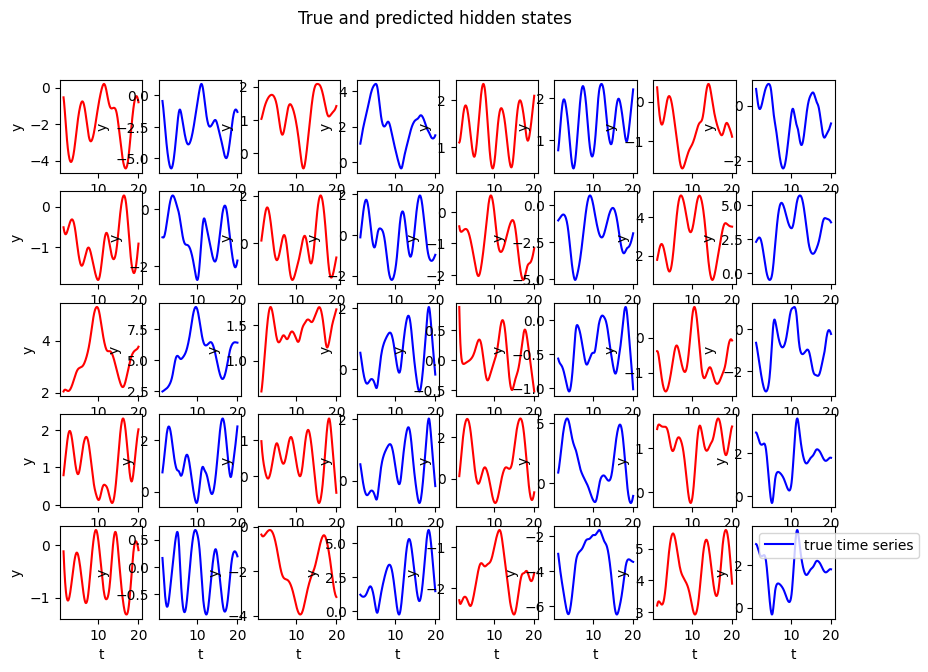

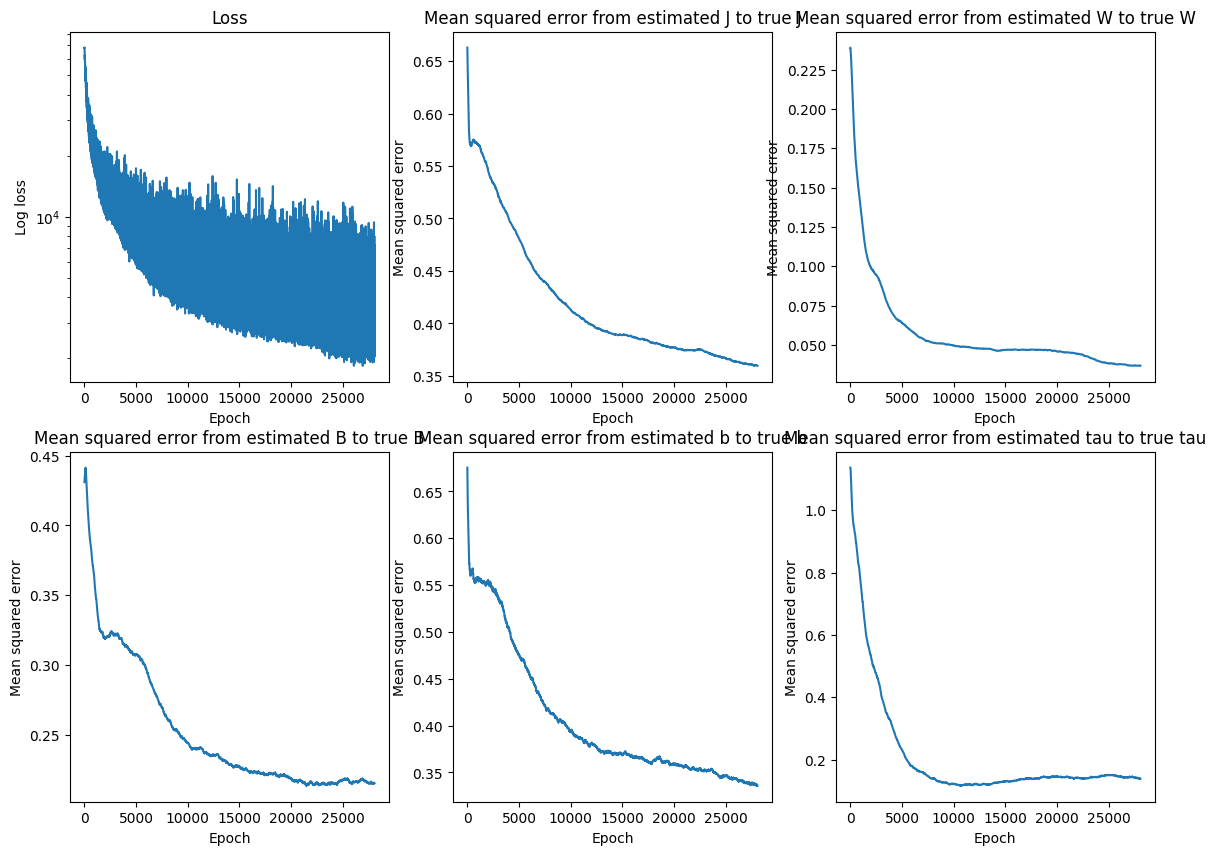

In [17]:
#Define number of neurons, control inputs and observations
N_obs = 15
N_neurons = 5
N_areas = 4
N = N_neurons*N_areas #neurons
C = 4 #control
M = N_obs*N_areas #observations

block = np.zeros((M,N))
for i in range(N_areas):
  block[N_obs*i : N_obs*(i+1), N_neurons*i : N_neurons*(i+1)] = 1

key = jrandom.PRNGKey(1)
keys = jrandom.split(key, num=4)

f_state = StateEquation(keys[0], N, C, True, 0.7)

#Observation function for the CDE
f_obs = ObsFunction(keys[1], block, True)

#Define CDE
system = CDE(f_state, f_obs)

#Time point that defines the starting point of the NCDE. The data before this point is used to predict the initial condition.
t0 = 20

#Sample path
T = 300
time_points = jnp.linspace(0, 20, T)

nr_batch = 64

#SD used to sample initial states
sd = 1

dataloader = Dataloader(system, keys[2], nr_batch, N, C, sd, nr_batch*250, nr_batch*2, time_points)

losses, Js, Bs, bs, Ws, taus, model = train_nn(keys[3], N, C, M, time_points, dataloader, t0=t0, block=block)
order, negative_neurons = find_block_order(model.f_obs.W, system.f_obs.W, N_obs, N_neurons, N_areas)
evaluate_model(model, dataloader, time_points, t0, order, negative_neurons, N_neurons, N_areas)
plot_figures(losses, Js, Bs, bs, Ws, taus, system, order)

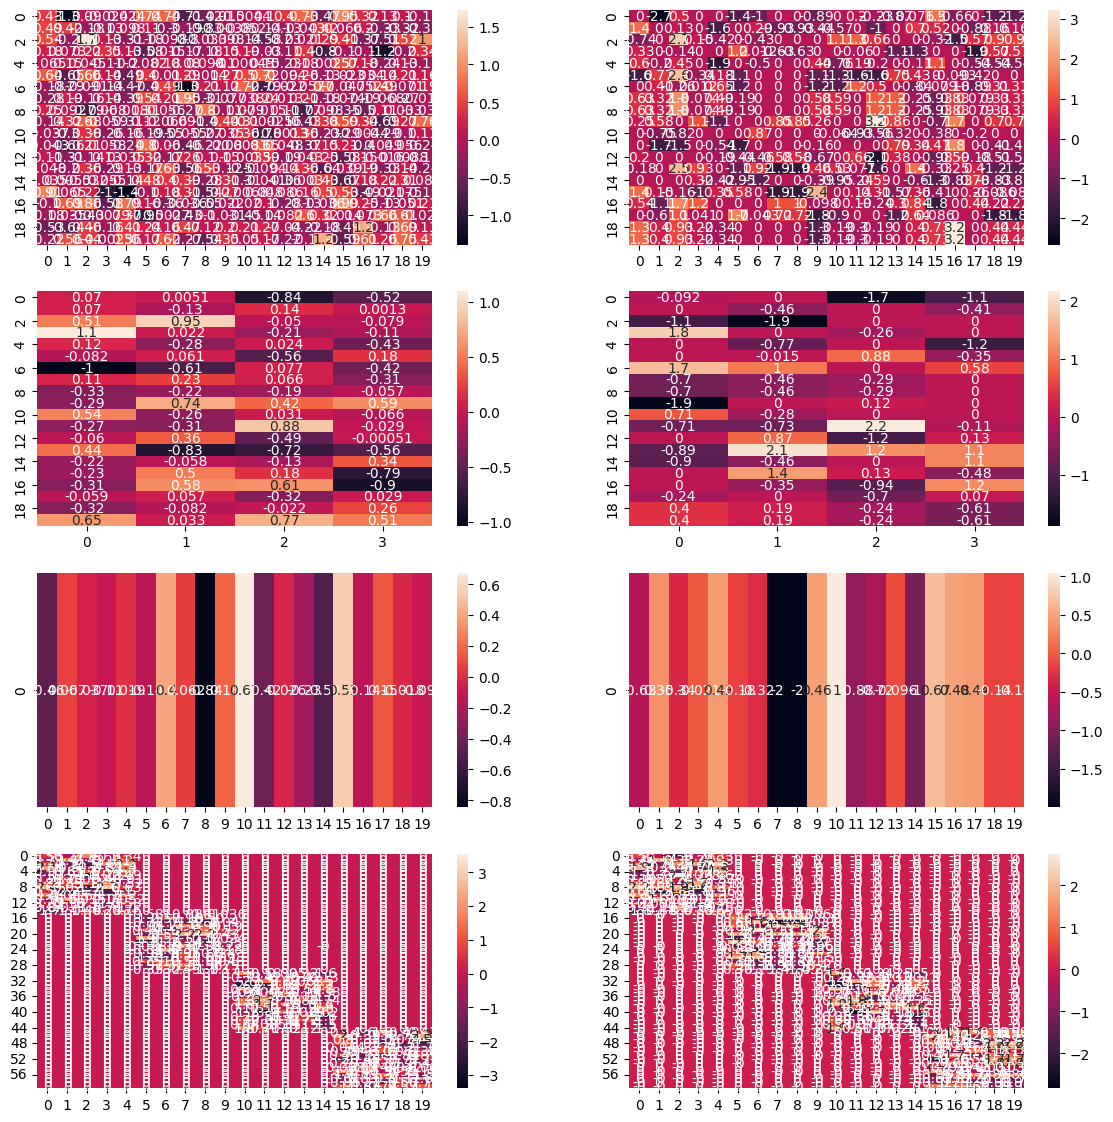

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
g1 = sns.heatmap(model.f_state.J,annot=True,ax=axes[0,0])
g2 = sns.heatmap([j[order] for j in system.f_state.J[order]],annot=True,ax=axes[0,1])
g3 = sns.heatmap(model.f_state.B,annot=True,ax=axes[1,0])
g4 = sns.heatmap(system.f_state.B[order],annot=True,ax=axes[1,1])
g5 = sns.heatmap([model.f_state.b],annot=True,ax=axes[2,0])
g6 = sns.heatmap([system.f_state.b[order]],annot=True,ax=axes[2,1])
g7 = sns.heatmap(model.f_obs.W,annot=True,ax=axes[3,0])
g8 = sns.heatmap(system.f_obs.W[:,order],annot=True,ax=axes[3,1])
plt.show()

In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
# dictionary = {'losses':losses, 'Js':Js, 'Bs':Bs, 'bs':bs, 'Ws':Ws, 'taus':taus, 'True_J':J,'True_B':B,'True_b':b,'True_W':W, 'True_tau':tau}
# np.save(f'/content/drive/MyDrive/Thesis_Data/large_I_2.npy', dictionary) 

In [21]:
# read_dictionary = np.load('/content/drive/MyDrive/Thesis_Data/N_6_t0_50.npy',allow_pickle='TRUE').item()
# plot_figures(losses, read_dictionary['Js'], read_dictionary['Bs'], read_dictionary['bs'], read_dictionary['Ws'], read_dictionary['True_J'], read_dictionary['True_B'], read_dictionary['True_b'], read_dictionary['True_W'], read_dictionary['x0s'], read_dictionary['x0'])